In [1]:
import torch
import logging
import queue
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np


### Implement DBSCAN

In [3]:
# 1. Define a distance function to compute distance between two tensors. E.g. Euclidean, Cosine, etc.
def euclidean_dist(a, b):
    """
        Compute the Euclidean distance between tensor a and tensor b
        Returns:
            torch.Tensor: A tensor `dst` where dst[i][j] is the Euclidean distance between tensor a[i] and tensor b[j]
    """

    # ||a - b||2 = ||a||2 + ||b||^2 - 2a*b.T

    norm_a = torch.sum(a**2, dim=1, keepdim=True)
    norm_b = torch.sum(b**2, dim=1, keepdim=True)

    return  torch.sqrt(norm_a + norm_b.T - 2 * torch.matmul(a, b.T))

In [4]:
# 2. Define a function to retrieve neighbors within an epsilon region

def retrieve_neighbors(anchor_idx, dist_mat, eps):
    """
    Retrieve the neighbors of anchor point based on distance matrix and radius eps
    Returns:
        List: A list of neighbor indices
    """

    neighbor_indices = torch.where(dist_mat[anchor_idx] <= eps)[0].tolist()

    return neighbor_indices



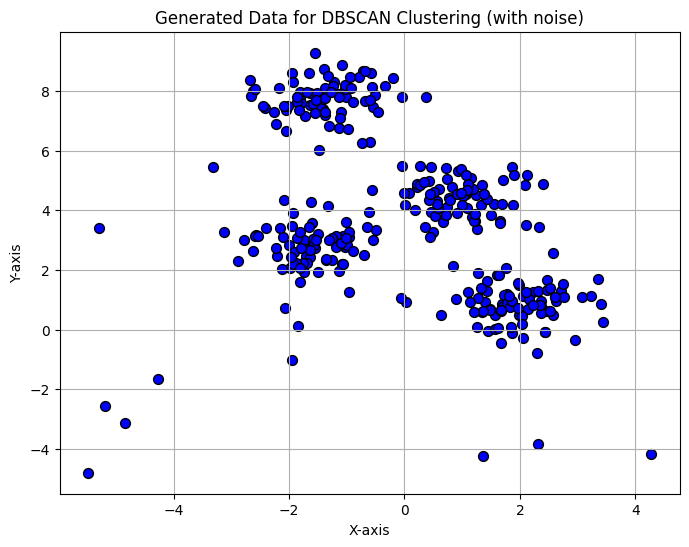

In [10]:
# Generate example data with blobs
# `make_blobs` generates isotropic Gaussian blobs for clustering.
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
# Add some noise (outliers)
X_with_noise = np.vstack([X, np.random.uniform(low=-6, high=6, size=(20, 2))])  # Add 20 random outliers

# Plot the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X_with_noise[:, 0], X_with_noise[:, 1], s=50, c='b', marker='o', edgecolor='k')
plt.title("Generated Data for DBSCAN Clustering (with noise)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.savefig("raw.png")
plt.show()
data = torch.tensor(X_with_noise)

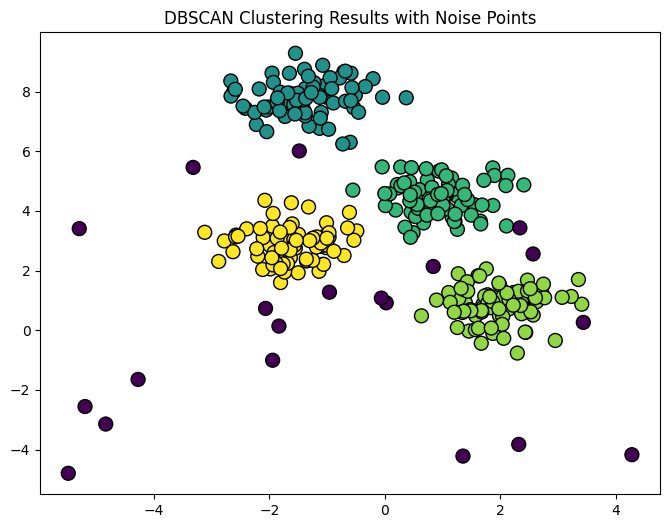

In [12]:
# 3. Implement DBSCAN algorithm 
minPts = 5                 # Minimum number of points required to form a dense region
eps = 0.65                 # Radius to consider neighbors
C = 0                      # Cluster label counter
Q = queue.Queue()          # Queue for expanding clusters
UNDEFINED = -1             # Label for unvisited points
NOISE = -2                 # Label for noise points

# Initialize all points as UNDEFINED
labels = torch.empty(data.size(0), ).fill_(UNDEFINED)

# Precompute the distance matrix
distance_mat = euclidean_dist(data, data)


for i in range(data.size(0)):
    if labels[i] != UNDEFINED:
        continue

    neighbors = retrieve_neighbors(anchor_idx=i, dist_mat=distance_mat, eps=eps) # i_idx is included
    if len(neighbors) < minPts:
        labels[i] = NOISE
    else: # qualified to form a cluster
        C += 1
        labels[i] = C
        neighbors.remove(i)  # Remove the point itself out of neighbors list 
        
        for neighbor in neighbors: # Add neighbors to queue
            Q.put(neighbor) 
            
        while not Q.empty():
            neighbor_index = Q.get()
            if labels[neighbor_index] != UNDEFINED:
                continue
                
            labels[neighbor_index] = C
            
            neighbors = retrieve_neighbors(anchor_idx=neighbor_index, dist_mat=distance_mat, eps=eps)
            
            if len(neighbors) >= minPts:
                neighbors.remove(neighbor_index)
                for neighbor in neighbors:
                    Q.put(neighbor)

plt.figure(figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=100)
plt.title("DBSCAN Clustering Results with Noise Points")
plt.savefig("dbscan_clusters.png")